# Visual Odometry
This notebook is for visual odometry that apply stereo vision depth estimation and multiple view geometry for tracking vehicle position and orientation within a sequence of image for kitti dataset.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Iterator, Optional, Literal

from dotenv import load_dotenv
from dataclasses import dataclass

_ = load_dotenv()

## Dataset Handler


In [ ]:
class DatasetHandler(object):
    def __init__(self, lidar: bool = False) -> None:
        self.ld = os.getenv('img_l_dir')
        self.rd = os.getenv('img_r_dir')
        self.lf = sorted(os.listdir(self.ld), key=lambda x: int(x.split('.')[0]))
        self.rf = sorted(os.listdir(self.rd), key=lambda x: int(x.split('.')[0]))
        self.frame_num: int = len(self.lf)
        
        # Ground truth
        p = pd.read_csv(os.getenv('poses_file'), delimiter=' ', header=None)
        self.gt: np.ndarray = p.values.reshape((-1, 3, 4))

        # Camera intrinsic matrix, and lidar transform matrix
        c = pd.read_csv(os.getenv('calib_file'), delimiter=' ', header=None, index_col=0)
        self.K0, self.K1, self.Tr = map(
            lambda x: np.array(c.loc[x, :]).reshape((3, 4)), ('P0:', 'P1:', 'Tr:')
        )

        # Point cloud
        self.lidar: bool = lidar
        if self.lidar:
            self.pcd = os.getenv('lidar_dir')
            self.pcf = sorted(os.listdir(self.pcd), key=lambda x: int(x.split('.')[0]))

        self._reset_frame()

    def frame(self) -> tuple:
        if self.lidar:
            return self.img_l0, self.img_r0, self.img_l1, self.pcl
        return self.img_l0, self.img_r0, self.img_l1, None 

    def next_frame(self) -> tuple:
        self.img_l0 = self.img_l1
        self.img_r0 = next(self.images_r)
        self.img_l1 = next(self.images_l)
        
        if self.lidar:
            self.pcl = next(self.pcs)
            return self.img_l0, self.img_r0, self.img_l1, self.pcl
        return self.img_l0, self.img_r0, self.img_l1, None
    
    @property
    def imsize(self) -> tuple[int, int]:
        return self.ih, self.iw

    def _reset_frame(self) -> None:
        self.images_l: Iterator[cv2.Mat] = (
            cv2.imread(os.path.join(self.ld, f), 0) for f in self.lf
        )
        self.images_r: Iterator[cv2.Mat] = (
            cv2.imread(os.path.join(self.rd, f), 0) for f in self.rf
        )

        self.img_l1 = next(self.images_l)
        self.ih: int = self.img_l1.shape[0]
        self.iw: int = self.img_l1.shape[1]

        if self.lidar:
            self.pcs: Iterator[np.ndarray] = (
                np.fromfile(os.path.join(self.pcd, f), dtype=np.float32, count=-1)
                for f in self.pcf
            )

In [23]:
class VisualOdometry(object):
    def __init__(
        self, 
        P0: np.ndarray, 
        P1: np.ndarray, 
        Tr: np.ndarray,
        isize: tuple[int, int],
        lidar: bool = False,
        stereo_matcher: Optional[Literal['sgbm', 'bm']] = None,
        detector: Literal['orb', 'sift'] = 'orb',
        matching: Literal['bf', 'flann'] = 'bf',
        matching_threshold: Optional[float] = None
    ) -> None:
        ## camera coefficient
        self.P0 = P0
        self.P1 = P1
        self.Tr = Tr
        self.K0, self.R0, self.t0, *_ = cv2.decomposeProjectionMatrix(self.P0)
        self.K1, self.R1, self.t1, *_ = cv2.decomposeProjectionMatrix(self.P1)
        self.f = self.K0[0, 0]
        self.b = self.t1[0] - self.t0[0]
        self.ih, self.iw = isize
        self.cx, self.cy = self.K0[0, 2], self.K0[1, 2]
        self.fx, self.fy = self.K0[0, 0], self.K0[1, 1]

        ## stereo matcher
        self._lidar: bool = lidar
        self._stereo_matcher: Optional[cv2.StereoBM | cv2.StereoSGBM] = None
        if stereo_matcher == 'sgbm':
            self._stereo_matcher = cv2.StereoSGBM.create(
                numDisparities=96,
                minDisparity=0,
                blockSize=11,
                P1 = 8 * 3 * 6 ** 2, 
                P2 = 32 * 3 * 6 ** 2,
                mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
            )
        elif stereo_matcher == 'bm':
            self._stereo_matcher = cv2.StereoBM.create(numDisparities=96, blockSize=11)

        ## feature detection and matching
        det: dict[str, cv2.ORB | cv2.SIFT] = {
            'orb': cv2.ORB.create,
            'sift': cv2.SIFT.create, 
        }
        self._feature_detector: cv2.SIFT | cv2.ORB = det[detector]()

        if matching == 'bf':
            self._feature_matcher = cv2.BFMatcher.create(
                cv2.NORM_L2 if detector == 'sift' else cv2.NORM_HAMMING2,
                crossCheck=False
            )
        else:
            self._feature_matcher = cv2.FlannBasedMatcher(
                dict(algorithm=1, trees=5), 
                dict(checks=50)
            )
        self.threshold: Optional[float] = matching_threshold

        ## trajectory
        self.T: np.ndarray = np.eye(4)
        self.traj: np.ndarray = np.zeros((1, 3, 4))
        self.traj[0] = self.T[:3, :]


    def update(
        self,
        image_l0: np.ndarray,
        image_r0: np.ndarray,
        image_l1: np.ndarray,
        point_clould: Optional[np.ndarray] = None
    ) -> None:
        
        depth: Optional[np.ndarray] = None
        if self._stereo_matcher:
            depth = self._depth_estimate(image_l0, image_r0, point_clould)

        ## feature extraction and matching
        kp0, des0 = self._feature_detector.detectAndCompute(image_l0, None)
        kp1, des1 = self._feature_detector.detectAndCompute(image_l1, None)

        m = self._features_matching(des0, des1)
        R, t = self._motion_estimate(kp0, kp1, m, depth)

        T_hom: np.ndarray = np.eye(4)
        T_hom[:3,:3] = R
        T_hom[:3, 3] = t.T
        self.T = self.T.dot(np.linalg.inv(T_hom))
        self.traj = np.vstack((self.traj, self.T[:3, :][np.newaxis, :, :]))
        
    def _depth_estimate(
        self, 
        image_l0: np.ndarray,
        image_r0: np.ndarray,
        point_clould: Optional[np.ndarray] = None
    ) -> np.ndarray:
        disp = self._stereo_matcher.compute(image_l0, image_r0).astype(np.float32) / 16
        disp = np.where((disp == 0.0) | (disp == -1.0), 0.1, disp)
        
        depth = (self.f * self.b) / disp
        if point_clould is not None or not self._lidar:
            return depth
        
        ## lidar depth correction
        pcl = point_clould[point_clould[:, 0] > 0]
        pcl = np.hstack([pcl[:, :3], np.ones((pcl.shape[0], 1))])
        cam = self.Tr @ pcl.T
        cam = cam[:, cam[2] > 0]
        dep = cam[2].copy()
        cam /= cam[2]
        cam = np.vstack([cam, np.ones(cam.shape[1])])

        project = self.P0 @ cam
        pixel_coord = project.T.round(0)[:, :2].astype(np.int32)

        indices = np.where(
            (pixel_coord[:, 0] < self.iw) &
            (pixel_coord[:, 1] < self.ih) &
            (pixel_coord[:, 0] >= 0) &
            (pixel_coord[:, 1] >= 0)
        )
        pixel_coord = pixel_coord[indices]
        dep = dep[indices]

        depth_map = np.zeros((self.ih, self.iw))
        for i, (u, v) in enumerate(pixel_coord):
            if u < 0 or u >= self.iw or v < 0 or v > self.ih:
                continue
            depth_map[v, u] = depth[i]
    
        depth_map[depth_map == 0.0] = 3000

        indices = np.where(depth_map < 3000)
        depth[indices] = depth_map[indices]
    
        return depth

    def _features_matching(
        self,
        des1: np.ndarray,
        des2: np.ndarray,
    ) -> list[cv2.DMatch]:
        matches = self._feature_matcher.knnMatch(des1, des2, 2)
        matches = sorted(matches, key=lambda x: x[0].distance)

        return [
            m for m, n in matches 
            if self.threshold is None or m.distance <= n.distance * self.threshold
        ]
    
    def _motion_estimate(
        self,
        kp1: list[cv2.KeyPoint],
        kp2: list[cv2.KeyPoint],
        matches: list[cv2.DMatch],
        depth: Optional[np.ndarray] = None,
        depth_max: int = 3000
    ) -> tuple[np.ndarray, np.ndarray]:
        R: np.ndarray = np.eye(3)
        t: np.ndarray = np.zeros((3, 1))

        pts_1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts_2 = np.float32([kp2[m.trainIdx].pt for m in matches])

        if depth is None: # apply essential matrix decomposition, scale ambiguous
            E, _ = cv2.findEssentialMat(pts_1, pts_2, self.K0)
            _, R, t, _ = cv2.recoverPose(E, pts_1, pts_2, self.K0)
            return R, t
        
        ## convert points in image1 into world coordinate with camera parameter and
        ## depth information, apply PnP algorithm with RANSAC for robustness to outlier
        pts_w = np.zeros((0, 3), dtype=np.float32)
        remove_idx: list[int] = []

        for i, (u, v) in enumerate(pts_1):
            z = depth[int(v), int(u)]
            if z > depth_max:
                remove_idx.append(i)
                continue

            x = z * (u - self.cx) / self.fx
            y = z * (v - self.cy) / self.fy
            pts_w = np.vstack([pts_w, np.array([x, y, z])])

        pts_2 = np.delete(pts_2, remove_idx, 0)
        _, R_vec, t, _ = cv2.solvePnPRansac(pts_w, pts_2, self.K0, None)
        R = cv2.Rodrigues(R_vec)[0]
        return R, t


In [26]:
%matplotlib inline

from tqdm import tqdm

handler = DatasetHandler(lidar=True)
vo = VisualOdometry(
    handler.K0,
    handler.K1,
    handler.Tr,
    handler.imsize,
    True,
    stereo_matcher='sgbm',
    detector='sift',
    matching_threshold=0.5
)

for _ in tqdm(range(handler.frame_num - 1)):
    image0, image1, image2, pcl = handler.next_frame()
    vo.update(image0, image1, image2, pcl)

100%|██████████| 1105/1105 [04:43<00:00,  3.89it/s]


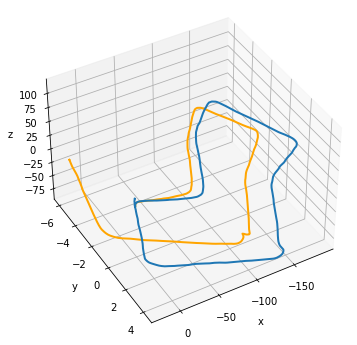

In [27]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(vo.traj[:, :, 3][:, 0],
        vo.traj[:, :, 3][:, 1],
        vo.traj[:, :, 3][:, 2],
        label='estimated', color='orange', linewidth=2)

ax.plot(handler.gt[:, :, 3][:, 0],
        handler.gt[:, :, 3][:, 1],
        handler.gt[:, :, 3][:, 2],
        label='ground truth', linewidth=2)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=40, azim=60)

In [45]:
def error(gt: np.ndarray, est: np.ndarray) -> None:
    fn: int = min(len(gt) - 1, est.shape[0])
    ae: np.ndarray = np.sqrt(
        np.power(gt[fn, 0, 3] - est[fn, 0, 3], 2) +
        np.power(gt[fn, 1, 3] - est[fn, 1, 3], 2) + 
        np.power(gt[fn, 2, 3] - est[fn, 2, 3], 2)
    )
    se: np.ndarray = np.power(ae, 2)

    mse = se.mean()
    mae = ae.mean()

    rmse = np.sqrt(mse)

    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}.")

In [47]:
error(handler.gt, vo.traj)

MAE: 33.6367, MSE: 1131.4299, RMSE: 33.6367.


In [7]:
%matplotlib inline

from tqdm import tqdm

handler = DatasetHandler()
vo = VisualOdometry(
    handler.K0,
    handler.K1,
    handler.Tr,
    handler.imsize,
    matching_threshold=0.5
)

for _ in tqdm(range(handler.frame_num - 1)):
    image0, image1, image2 = handler.next_frame()
    vo.update(image0, image1, image2)

  0%|          | 0/1105 [00:00<?, ?it/s]

100%|██████████| 1105/1105 [00:32<00:00, 34.22it/s]


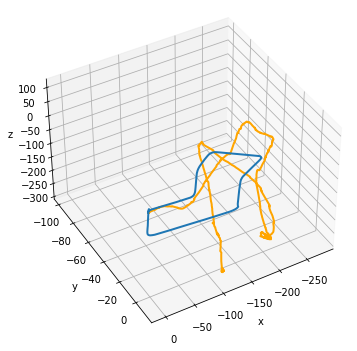

In [ ]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(vo.traj[:, :, 3][:, 0],
        vo.traj[:, :, 3][:, 1],
        vo.traj[:, :, 3][:, 2],
        label='estimated', color='orange', linewidth=2)

ax.plot(handler.gt[:, :, 3][:, 0],
        handler.gt[:, :, 3][:, 1],
        handler.gt[:, :, 3][:, 2],
        label='ground truth', linewidth=2)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=40, azim=60)

In [11]:
%matplotlib inline
handler = DatasetHandler()
vo = VisualOdometry(
    handler.K0,
    handler.K1,
    handler.Tr,
    handler.imsize,
    stereo_matcher='bm',
    matching_threshold=0.45
)

for _ in tqdm(range(handler.frame_num - 1)):
    image0, image1, image2 = handler.next_frame()
    vo.update(image0, image1, image2)

100%|██████████| 1105/1105 [00:42<00:00, 25.87it/s]


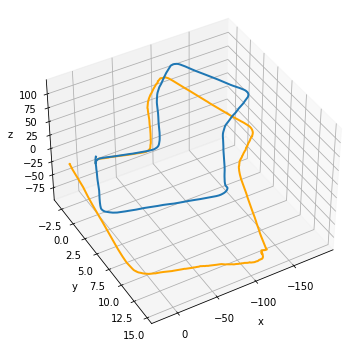

In [13]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(vo.traj[:, :, 3][:, 0],
        vo.traj[:, :, 3][:, 1],
        vo.traj[:, :, 3][:, 2],
        label='estimated', color='orange', linewidth=2)

ax.plot(handler.gt[:, :, 3][:, 0],
        handler.gt[:, :, 3][:, 1],
        handler.gt[:, :, 3][:, 2],
        label='ground truth', linewidth=2)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=40, azim=60)